In [158]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

datafilename = "data_processed-without-outliers.csv"
d = pd.read_csv(datafilename)
print("Loading", len(d), "lines of data.")

resultsfilename = "data_stats-without-outliers.csv"
st = pd.read_csv(resultsfilename)
print("Loading", len(st), "lines of stats.")

# functions to calculate AUC and plot ROC

def cummulative(x):
    return [sum(x[0:i+1]) for i in range(len(x))]

def get_auc(x, y):
    # make cummulative
    x, y = cummulative(x), cummulative(y)
    # normalize
    x = [xi/max(x) for xi in x]
    y = [yi/max(y) for yi in y]
    auc = 0
    x1, y1 = 0, 0
    for x2, y2 in zip(x, y):
        auc += (x2 - x1) * (y1 + y2) / 2
        x1, y1 = x2, y2
    return auc

def plot_roc(x, y):
    x, y = cummulative(x), cummulative(y)
    plt.plot((min(x), max(x)), (min(y), max(y)), color='red', linewidth=1, linestyle='--')
    for i in range(len(x)-1):
        plt.plot((x[i], x[i+1]), (y[i], y[i+1]
                                 ), color='black', linewidth=1)
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker='o', s=30, color='black')
    #plt.xlim(0.0, 1.0)
    #plt.ylim(0.0, 1.0)
    plt.show()

Loading 13875 lines of data.
Loading 772 lines of stats.


In [159]:
# comparison by design expertise

types = ["lexical", "recognition"]
fonts = ["arial", "sansforgetica"]
skills = ["Designer", "Non-designer"]
metrics = ["Response time", "Response time (word)", "Response time (non-word)", "AUC", "AUC (word)", "AUC (non-word)"]
RTs = metrics[:3]
AUCs = metrics[3:]

cols = pd.MultiIndex.from_product([skills, metrics, ["mean", "SEM"]], names=["skill", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types, fonts], names=["sid", "type", "font"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t, font in res.index:
    for skill in skills:
        if skill == "Designer":
            r = st[st["isDesigner"] & (st["Font"] == font) & (st["Test type"] == t) & (st["Study ID"] == sid)]
        else:
            r = st[(st["isDesigner"] == False) & (st["Font"] == font) & (st["Test type"] == t) & (st["Study ID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t, font), (skill, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t, font), (skill, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-design-expertise.csv")

skill                              Designer                                \
metric                        Response time          Response time (word)   
stat                                   mean      SEM                 mean   
sid type        font                                                        
1   lexical     arial               2510.19  113.399              1678.88   
                sansforgetica       2796.17  141.712              1930.02   
    recognition arial               2383.73  88.0139              2297.41   
                sansforgetica       2559.68  109.214              2408.27   
2   lexical     arial               2425.58   137.95              1728.13   
                sansforgetica       2996.23  167.053              2024.46   
    recognition arial               2473.16  90.4801              2306.34   
                sansforgetica       2646.86  107.114              2335.78   

skill                                                                     \
metric                                 Response time (non-word)            
stat                               SEM                     mean      SEM   
sid type        font                                                       
1   lexical     arial          52.1944                  3354.52  204.368   
                sansforgetica  81.0032                  3790.39  318.224   
    recognition arial           104.78                   2468.6  91.0812   
                sansforgetica  107.694                   2713.2  132.445   
2   lexical     arial          73.4953                   3123.1  243.738   
                sansforgetica  91.7656                  3996.28  298.077   
    recognition arial          95.1365                  2637.86  130.032   
                sansforgetica  90.0246                  2957.94  169.255   

skill                                                                      \
metric                              AUC             AUC (word)              
stat                               mean         SEM       mean        SEM   
sid type        font                                                        
1   lexical     arial          0.972526  0.00654796        NaN        NaN   
                sansforgetica  0.979423  0.00527942        NaN        NaN   
    recognition arial          0.898374   0.0144807   0.880307   0.018187   
                sansforgetica   0.89073   0.0162245   0.870283  0.0213533   
2   lexical     arial          0.954619   0.0128194        NaN        NaN   
                sansforgetica  0.935147   0.0163015        NaN        NaN   
    recognition arial          0.839833   0.0188993   0.846814  0.0242734   
                sansforgetica  0.843444   0.0190978    0.86152  0.0216905   

skill                            ...             Non-designer           \
metric                           ...     Response time (word)            
stat                             ...                     mean      SEM   
sid type        font             ...                                     
1   lexical     arial            ...                  2154.98  130.863   
                sansforgetica    ...                  2378.54  154.536   
    recognition arial            ...                  2815.68  152.576   
                sansforgetica    ...                  2679.59  113.896   
2   lexical     arial            ...                  1934.95  103.112   
                sansforgetica    ...                  2091.35  87.6688   
    recognition arial            ...                  2476.71  98.2226   
                sansforgetica    ...                  2699.81  107.222   

skill                                                                      \
metric                        Response time (non-word)                AUC   
stat                                              mean      SEM      mean   
sid type        font                                                        
1   lexical     arial                   

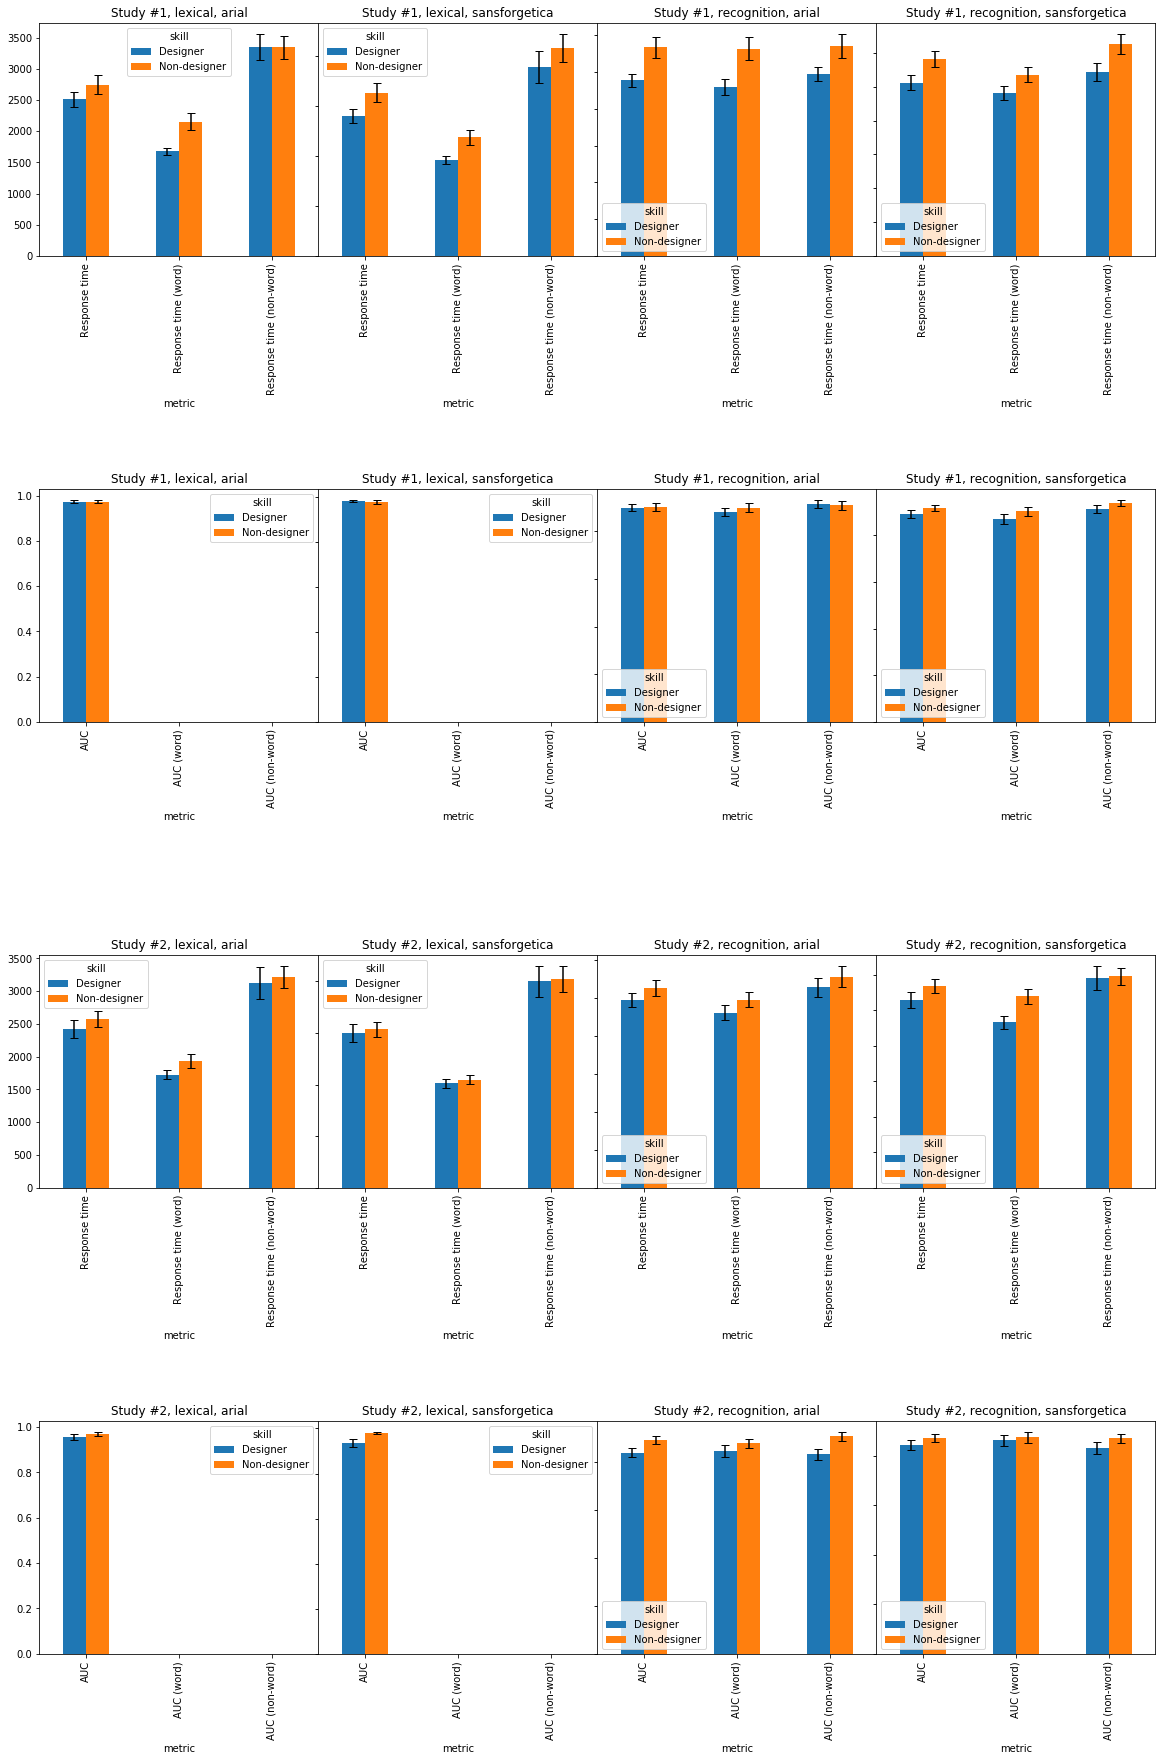

In [160]:
# comparison by design expertise - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 4, figsize=(20, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

combinations = [(t, f) for t in types for f in fonts]

for sid in [1, 2]:
    for i, (t, font) in enumerate(combinations):
        line = (sid - 1) * 2
        combo = (sid, t, font)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % (sid, t, font))
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % (sid, t, font))
fig.savefig("results/means-by-design-expertise.pdf")

In [161]:
# comparison by order

cols = pd.MultiIndex.from_product([[1, 2], metrics, ["mean", "SEM"]], names=["order", "metric", "stat"])
ix = pd.MultiIndex.from_product([[1, 2], types, fonts], names=["sid", "type", "font"])
res = pd.DataFrame(columns=cols, index=ix)

for sid, t, font in res.index:
    for tid in [1, 2]:
        r = st[(st["Test ID"] == tid) & (st["Font"] == font) & (st["Test type"] == t) & (st["Study ID"] == sid)]
        for metric in metrics:
            res.loc[(sid, t, font), (tid, metric, "mean")] = r[metric].mean()
            res.loc[(sid, t, font), (tid, metric, "SEM")] = r[metric].sem()
display(res)
res.to_csv("results/means-by-order.csv")

order                                     1                                \
metric                        Response time          Response time (word)   
stat                                   mean      SEM                 mean   
sid type        font                                                        
1   lexical     arial               2939.38  139.353              2043.49   
                sansforgetica          2874  183.659              2018.46   
    recognition arial               2840.47  127.943              2757.26   
                sansforgetica       2726.84  91.3963              2492.08   
2   lexical     arial               2614.18  157.626              1901.14   
                sansforgetica       3120.35  128.783              2037.05   
    recognition arial               2524.87  100.925              2395.18   
                sansforgetica       2545.78  69.4021              2323.05   

order                                                                     \
metric                                 Response time (non-word)            
stat                               SEM                     mean      SEM   
sid type        font                                                       
1   lexical     arial          121.182                  3843.39  203.754   
                sansforgetica  113.994                  3883.32  378.094   
    recognition arial          138.452                  2923.27  141.114   
                sansforgetica  93.0824                  2963.98   117.64   
2   lexical     arial          97.6676                  3327.32  272.141   
                sansforgetica  72.8737                  4203.64  207.245   
    recognition arial          102.234                  2652.22  143.569   
                sansforgetica  82.6461                   2768.5  98.1956   

order                                                                      \
metric                              AUC             AUC (word)              
stat                               mean         SEM       mean        SEM   
sid type        font                                                        
1   lexical     arial          0.961278  0.00837392        NaN        NaN   
                sansforgetica  0.984043  0.00529132        NaN        NaN   
    recognition arial          0.902879   0.0164754   0.886875    0.01763   
                sansforgetica  0.916508   0.0137257   0.893617  0.0235451   
2   lexical     arial          0.952512   0.0148853        NaN        NaN   
                sansforgetica    0.9654  0.00753338        NaN        NaN   
    recognition arial           0.84688    0.017552   0.846467  0.0226105   
                sansforgetica   0.83125    0.017093     0.8325  0.0207627   

order                            ...                        2           \
metric                           ...     Response time (word)            
stat                             ...                     mean      SEM   
sid type        font             ...                                     
1   lexical     arial            ...                  1736.71  57.3056   
                sansforgetica    ...                  2241.59  125.849   
    recognition arial            ...                   2293.4  114.981   
                sansforgetica    ...                  2568.25   126.82   
2   lexical     arial            ...                   1755.1  79.7737   
                sansforgetica    ...                   2076.2  107.115   
    recognition arial            ...                  2377.93  93.0958   
                sansforgetica    ...                  2705.74  112.834   

order                                                                      \
metric                        Response time (non-word)                AUC   
stat                                              mean      SEM      mean   
sid type        font                                                        
1   lexical     arial                   

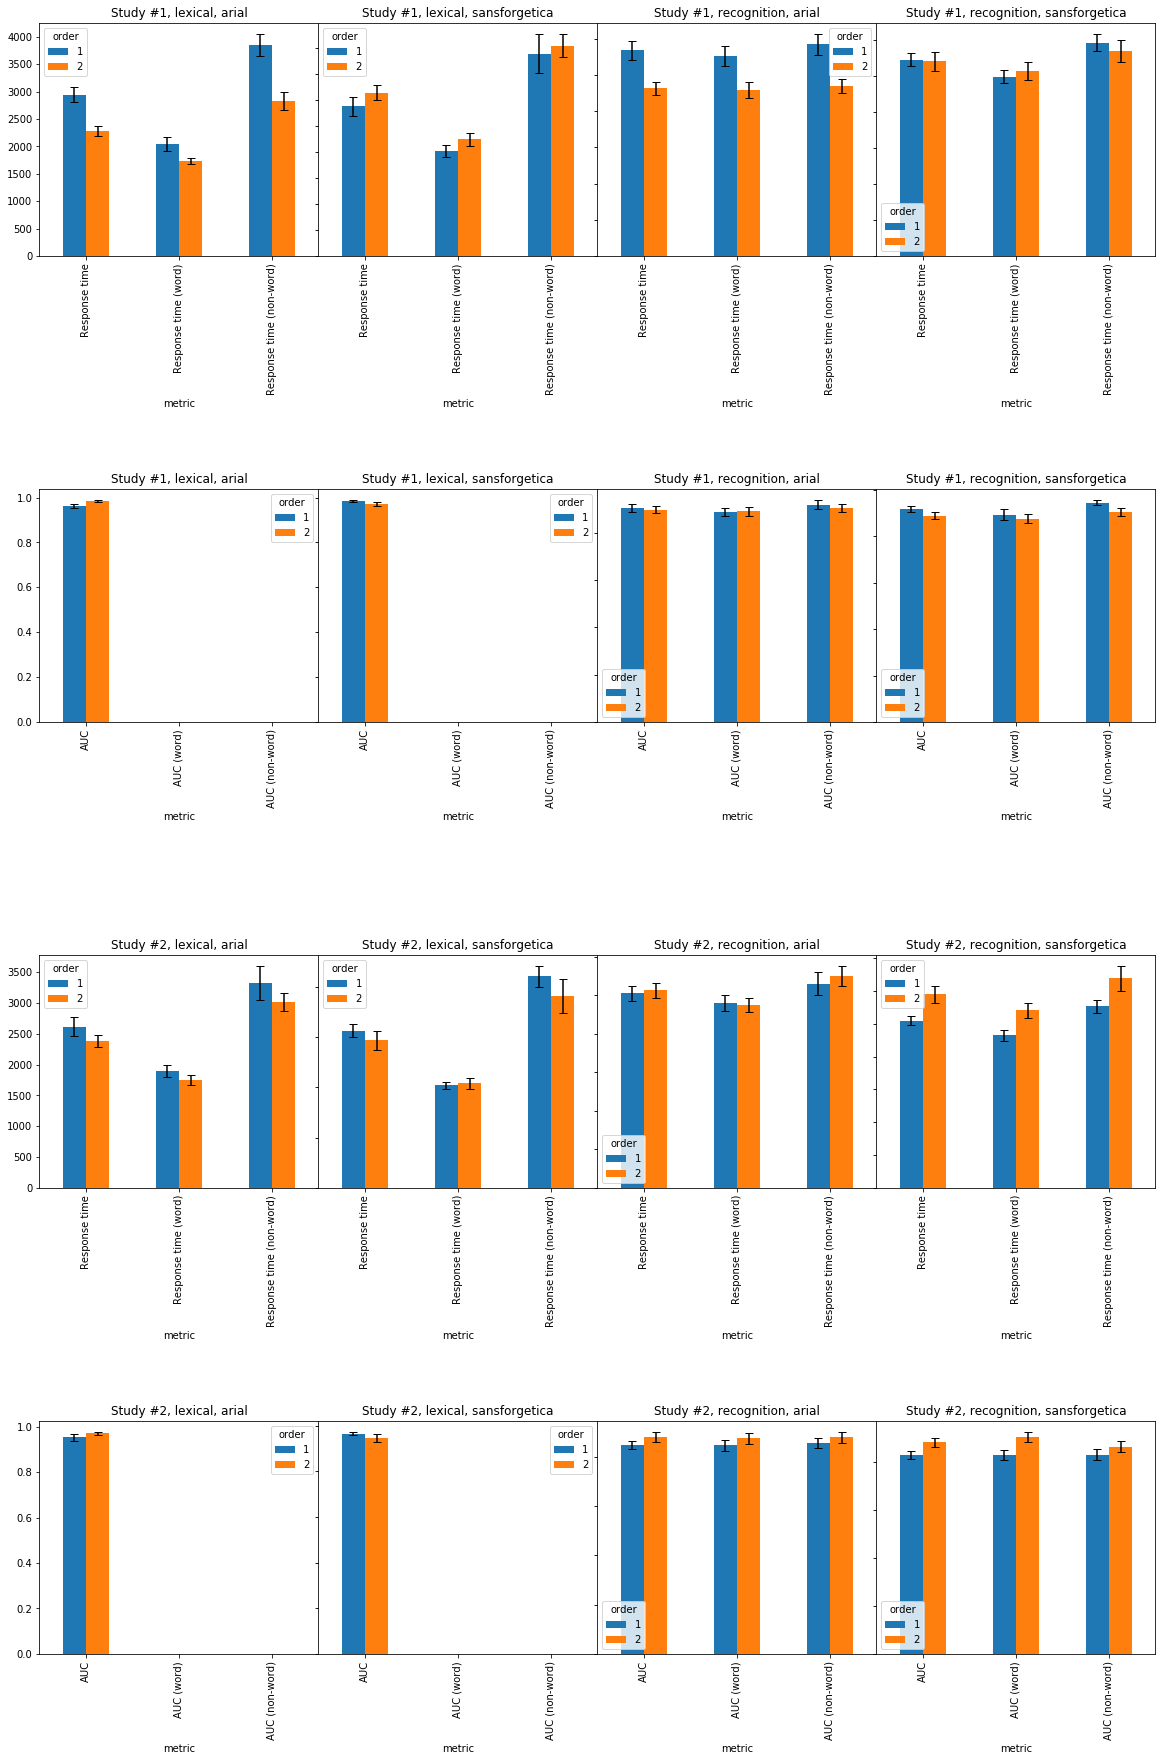

In [162]:
# comparison by order - charts

res_ = res.reorder_levels([2, 1, 0], axis=1).copy()
fig, axes = plt.subplots(4, 4, figsize=(20, 30))
plt.subplots_adjust(wspace=0, hspace=1)

res_ = res_.T.unstack()

combinations = [(t, f) for t in types for f in fonts]

for sid in [1, 2]:
    for i, (t, font) in enumerate(combinations):
        line = (sid - 1) * 2
        combo = (sid, t, font)
        means = res_.loc[("mean", ), combo].loc[RTs]
        errors = res_.loc[("SEM", ), combo].loc[RTs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % (sid, t, font))
        means = res_.loc[("mean", ), combo].loc[AUCs]
        errors = res_.loc[("SEM", ), combo].loc[AUCs]
        means.plot.bar(yerr=errors,
                       capsize=4,
                       ax=axes[line+1][i],
                       sharey=True,
                       title="Study #%d, %s, %s" % (sid, t, font))
fig.savefig("results/means-by-order.pdf")